## Predicting Iowa House Prices with Linear Regression and Regularization
This project predicted house prices in Ames, Iowa with 79 features (2006-2010). The training set had 1460 observations and the test set had 1459 observations. 

I engineered features for linear regression models, and trained OLS, Lasso, Ridge, and Elastic Net in this notebook 

#### Feature Engineering:
* Outliers
* Skewness
* Missing Values 
* Categorical Variables (One-hot Encoding)

#### Models:
* OLS
* Lasso
* Ridge
* Elastic Net
* All with PCA

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew 
from scipy import stats

#import libraries--feature engineering
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#import libraries--modeling
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import os
import warnings
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warnings from sklearn and seaborn

#setup graphs
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [2]:
#import datasets
train = pd.read_csv('/Users/qingchuanlyu/Documents/Application/Projects/Iowa Housing/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/qingchuanlyu/Documents/Application/Projects/Iowa Housing/house-prices-advanced-regression-techniques/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

#### Feature Engineering

In [3]:
#fix outlier: YrSold is earlier than YrBuilt for the observation 1089 in the test data
test.loc[1089]["YrSold"] = 2009
test.loc[1089]["YrActualAge"] = 0

In [4]:
#store the 'Id' column then drop it from original datasets--not used in modeling
#axis = 1 indicates col
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

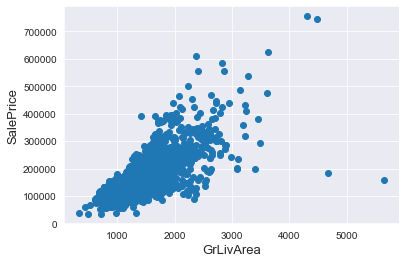

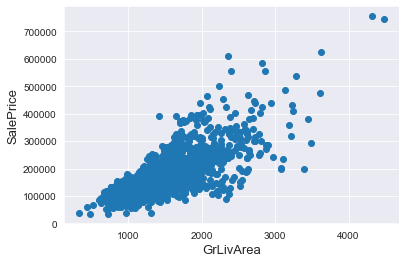

In [5]:
###Outliers
#use a scatter plot to observation the relationshiop between living areas and prices
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Delete outliers in the bottom-right corner of the scatter plot
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check distribution again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



Text(0.5, 1.0, 'SalePrice distribution')

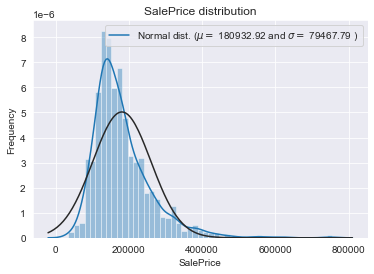

In [6]:
#Target variable
#Check the distribution of target variable: saleprice
sns.distplot(train['SalePrice'] , fit=norm);

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plot the distribution of salesprice
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


 mu = 12.02 and sigma = 0.40



Text(0.5, 1.0, 'SalePrice distribution')

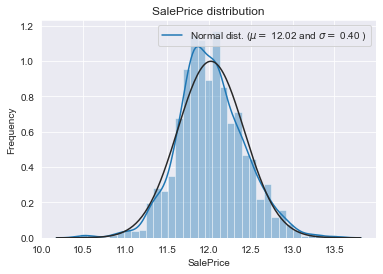

In [7]:
# Label is a little right-skewed. Use log transformation to make it more normally distributed.
#use the numpy fuction log1p to apply log(1+x): plus 1 to avoid -inf
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution again
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [8]:
#predictors in the training set
y_train = train.SalePrice.values

[Text(0.5, 1.0, 'Missing GarageType by Neighborhood')]

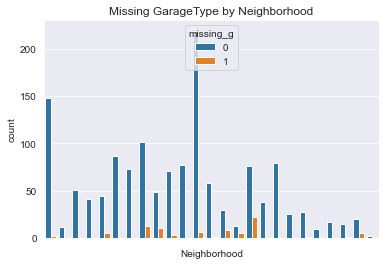

In [9]:
#check if missing values are Missing at Random, Missing completely at Random, or Not Missing at Random
#Assign label "None" to missing values:
for col in ('MSSubClass', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
#check if GarageType is missing completely at random
train['missing_g'] = np.where(train['GarageType']=="None", 1, 0)
#Check distribution of counts of each garage type with seaborn
ax = sns.countplot(x ='Neighborhood', hue = 'missing_g', data = train)
ax.set(xticklabels=[])
ax.set(title='Missing GarageType by Neighborhood')
#missing values of garage types spread across a few neighborhoods, so keep "None"

In [10]:
#check the number of missing values among all variables
train.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
missing_g          0
Length: 81, dtype: int64

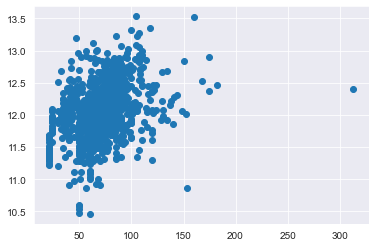

In [11]:
plt.scatter(train['LotFrontage'], train['SalePrice'])

In [12]:
#saleprice increases with lotfrontage
#next, check if missing lotfrontage concentrate in larger or samller values
train.loc[train.LotFrontage.isnull() == True][['SalePrice']].mean()

SalePrice   12.062
dtype: float64

In [13]:
train.loc[train.LotFrontage.isnull() == False][['SalePrice']].mean()

SalePrice   12.016
dtype: float64

[Text(0.5, 1.0, 'Missing LotFrontage by Neighborhood')]

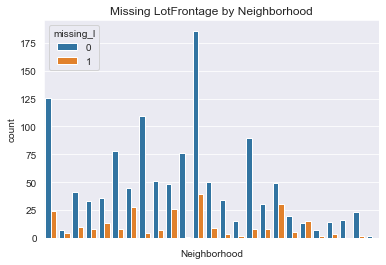

In [14]:
#check if missing LotFrontage concentrate in a few neighborhoods
train['missing_l'] = np.where(train['LotFrontage'].isnull(), 1, 0)
ax = sns.countplot(x = 'Neighborhood', hue = 'missing_l', data = train)
ax.set(xticklabels=[])
ax.set(title='Missing LotFrontage by Neighborhood')
#missing LotFrontage spreads out across different neighborhoods

In [15]:
#check if mean and median of lotfrontage is different across neighborhoods
lotfrontage_by_ngh = train.groupby(['Neighborhood']).\
                    agg(mean_lotfrontage = ('LotFrontage', 'mean'), \
                        med_lotfrontage=('LotFrontage', 'median')).\
                    reset_index()

In [16]:
lotfrontage_by_ngh.head(15)

,Neighborhood,mean_lotfrontage,med_lotfrontage
0,Blmngtn,47.143,43.000
1,Blueste,24.000,24.000
2,BrDale,21.562,21.000
3,BrkSide,57.510,52.000
4,ClearCr,83.462,80.000
5,CollgCr,71.683,70.000
6,Crawfor,71.805,74.000
7,Edwards,64.811,64.500
8,Gilbert,79.878,65.000
9,IDOTRR,62.500,60.000


In [17]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood in the training set
#median, mean functions are not affected by missing values. first, obtain the median of training data
nbh_lot = train.groupby(train.Neighborhood)[['LotFrontage']].median()
#med_lot = neigh_lot.groupby("Neighborhood")["LotFrontage"].transform("median")
#all["LotFrontage"] = all["LotFrontage"].fillna(med_lot)
#all.loc[all.Neighborhood.isin(neigh_lot.Neighborhood), ['LotFrontage']] = neigh_lot['LotFrontage']
train = train.merge(nbh_lot, on=["Neighborhood"], how='left', suffixes=('','_'))
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage_']).astype(int)
train = train.drop('LotFrontage_', axis=1)

In [18]:
#GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
for col in ('MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
#Remove "Utilities"-- For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA .
train = train.drop(['Utilities'], axis=1)
#Functional : data description says NA means typical
train["Functional"] = train["Functional"].fillna("Typical")
#vars with only one NA value, use mode of this var in the training set to prevent data leakage
for col in ('KitchenQual', 'Electrical', 'Exterior1st', 'Exterior2nd', 'MSZoning', 'SaleType'):
    train[col] = train[col].fillna(train[col].mode()[0])

In [19]:
#Changing OverallCond into a categorical variable
train['OverallCond'] = train['OverallCond'].apply(str)

#Year and month sold are transformed into categorical features.
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [20]:
# extract categorical variables
cates = train.select_dtypes(include=['object', 'category']).columns
# process columns, apply LabelEncoder to categorical features
for c in cates:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))

In [21]:
#use one-hot encoder to transfer categorical values to omit orders indicated by label encoders and prepare for PCA
train = pd.get_dummies(train)
print(train.shape)

(1458, 81)


In [22]:
###clean Skewed features
#extract numerical features
num_vars = train.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_vars = train[num_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_vars})
skewness.head(15)

# apply Box Cox Transformation to (highly) skewed features
skewness = skewness[abs(skewness) > 0.8]
skewed_features = skewness.index
lam = 0.25
for f in skewed_features:
    train[f] = boxcox1p(train[f], lam)

In [23]:
#drop price from training data
train = train.drop('SalePrice', axis = 1)

#### Modeling

In [24]:
metric = 'neg_root_mean_squared_error'
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [25]:
#try a simple linear regression first
print(f"{(-cross_val_score(LinearRegression(), train, y_train, cv=kfold, scoring=metric)).mean():.4f} Error")

0.1245 Error


In [26]:
#Lasso
lasso = Lasso(alpha= 0.003, random_state=1)
param_grid_lasso = {
                    'lasso__alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_lasso = GridSearchCV(estimator = lasso, param_grid=param_grid_lasso, cv=10, scoring=metric, n_jobs=-1)
search_lasso.fit(train, y_train)
print(f"{search_lasso.cv_results_['std_test_score'][search_lasso.best_index_]}")
print(f"{(-search_lasso.best_score_):.4}")

{'lasso__alpha': 0.00039999999999999996}
0.010886017421590542
0.1191


In [27]:
#Ridge
ridge = Ridge(alpha= 0.003, random_state=1)
param_grid_ridge = {
                    'ridge__alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_ridge = GridSearchCV(estimator = ridge, param_grid = param_grid_ridge, cv=10, scoring=metric, n_jobs=-1)
search_ridge.fit(train, y_train)
print(f"{search_ridge.best_params_}")
print(f"{(-search_ridge.best_score_):.4}")

{'ridge__alpha': 0.001}
0.1205


In [28]:
#elastic net
elastic_net = ElasticNet(alpha= 0.0005, 
                         l1_ratio= 0.4, 
                         random_state=1)
param_grid_el = {
                'elasticnet__alpha' : np.linspace(0.0001, 0.001, 10),
                'elasticnet__l1_ratio' : np.linspace(0.6, 0.95, 20),
                }
search_el = GridSearchCV(estimator = elastic_net, param_grid = param_grid_el, cv=10, scoring=metric, n_jobs=-1)
search_el.fit(train, y_train)
print(f"{search_el.best_params_}")
print(f"{search_el.cv_results_['std_test_score'][search.best_index_]}")
print(f"{(-search_el.best_score_):.4}")

{'elasticnet__alpha': 0.0005, 'elasticnet__l1_ratio': 0.8210526315789473}
0.010870458804764681
0.1191


In [29]:
### PCA
#standardize dataset -- preparing for PCA: too many features
scaler = StandardScaler()
#fit on training set only.
scaler.fit(train)
# Apply transform to both the training set and the test set.
train_scaled = scaler.transform(train)

#pca: reducing dimensionality of features; getting rid of collinear features
#choose the minimum number of principal components such that 95% of the variance is retained
pca = PCA(.95)
pca.fit(train_scaled)
train_pca = pca.transform(train_scaled)

In [30]:
#OLS with PCA
#try a simple linear regression first
print(f"{(-cross_val_score(LinearRegression(), train_pca, y_train, cv=kfold, scoring=metric)).mean():.4f} Error")

0.1286 Error


In [31]:
#Lasso with PCA
lasso_pca = Lasso(alpha= 0.003, random_state=1)
param_grid = {
            'lasso__alpha' : np.linspace(0.0001, 0.001, 10)
            }
search = GridSearchCV(lasso_pca, param_grid, cv=10, scoring=metric, n_jobs=-1)
search.fit(train_pca, y_train)
print(f"{search.best_params_}")
print(f"{(-search.best_score_):.4}")

{'lasso__alpha': 0.0007}
0.1271


In [32]:
#Ridge with PCA
ridge_pca = Ridge(alpha= 0.003, random_state=1)
param_grid = {
            'ridge__alpha' : np.linspace(0.0001, 0.001, 10)
            }
search = GridSearchCV(ridge_pca, param_grid, cv=10, scoring=metric, n_jobs=-1)
search.fit(train_pca, y_train)
print(f"{search.best_params_}")
print(f"{(-search.best_score_):.4}")

{'ridge__alpha': 0.001}
0.1273


In [33]:
#elastic net with PCA
elastic_net_pca = ElasticNet(alpha= 0.0005, 
                  l1_ratio= 0.4, 
                  random_state=1)
param_grid = {
                'elasticnet__alpha' : np.linspace(0.0001, 0.001, 10),
                'elasticnet__l1_ratio' : np.linspace(0.6, 0.95, 20),
                }
search = GridSearchCV(elastic_net_pca, param_grid, cv=10, scoring=metric, n_jobs=-1)
search.fit(train_pca, y_train)
print(f"{search.best_params_}")
print(f"{search.cv_results_['std_test_score'][search.best_index_]}")
print(f"{(-search.best_score_):.4}")

{'elasticnet__alpha': 0.0007, 'elasticnet__l1_ratio': 0.95}
0.012140182996239066
0.1271
